### Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

In [153]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
cali = pd.read_csv('data/housing.csv')

In [28]:
cali.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [29]:
cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Exploratory Data Analysis

<Axes: xlabel='total_rooms', ylabel='total_bedrooms'>

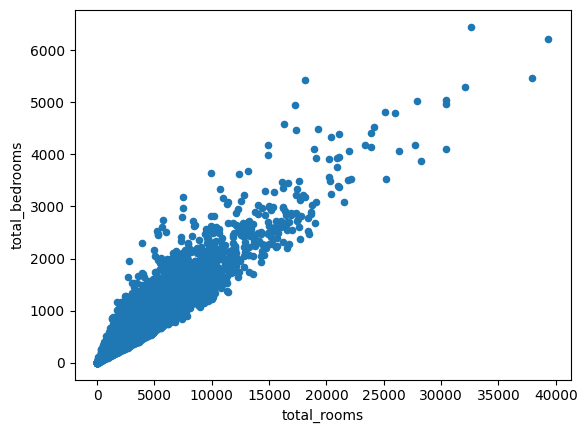

In [32]:
# total_bedrooms has missing values, but looks correlated to total_rooms
# I will use `IterativeImputer` in the sklearn pipeline to impute total_bedrooms
# from total_rooms
cali.plot(kind='scatter', x='total_rooms', y='total_bedrooms')

In [92]:
# There are only 5 records of ISLANDs, so I'll drop them from the data set
display(cali.query('ocean_proximity == "ISLAND"'))
df = cali.query('ocean_proximity != "ISLAND"').reset_index(drop=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8314,-118.32,33.35,27.0,1675.0,521.0,744.0,331.0,2.1579,450000.0,ISLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,414700.0,ISLAND
8316,-118.32,33.33,52.0,2127.0,512.0,733.0,288.0,3.3906,300000.0,ISLAND
8317,-118.32,33.34,52.0,996.0,264.0,341.0,160.0,2.7361,450000.0,ISLAND
8318,-118.48,33.43,29.0,716.0,214.0,422.0,173.0,2.6042,287500.0,ISLAND


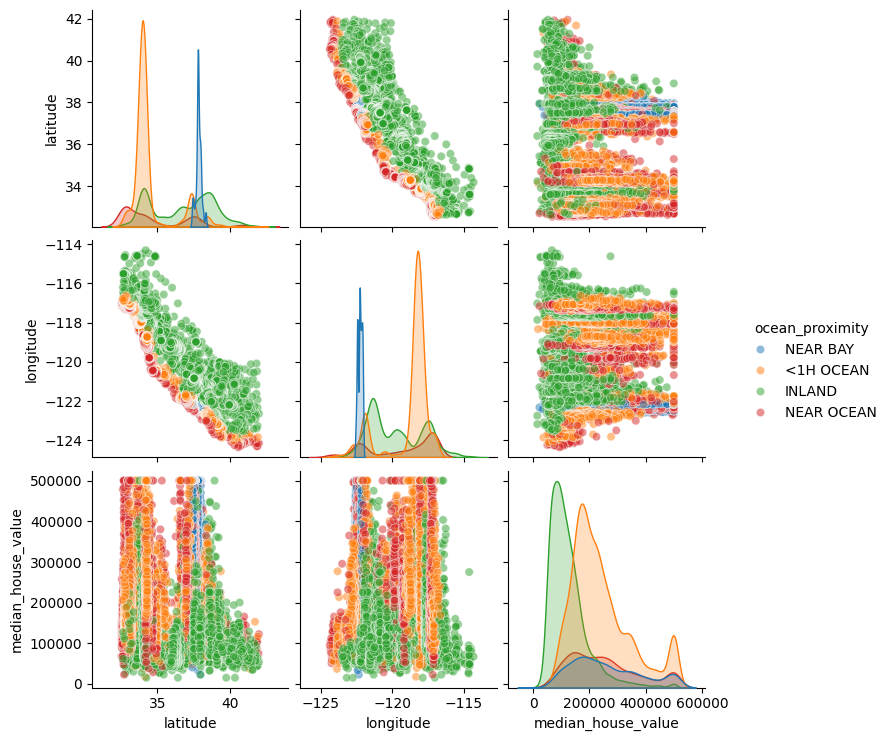

In [49]:
# Check dimensions related to location, see if we can cluster or drop
# highly correlated or irrelevant dimensions

# There seem to be 2 bands in lat and long what distribute across median_house_value
# Other values have much less median_house_value

# ocean_proximity seems to capture some of the variation, but not all
sns.pairplot(df[['latitude','longitude','median_house_value','ocean_proximity']],
             hue='ocean_proximity', plot_kws={'alpha':0.5})

<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

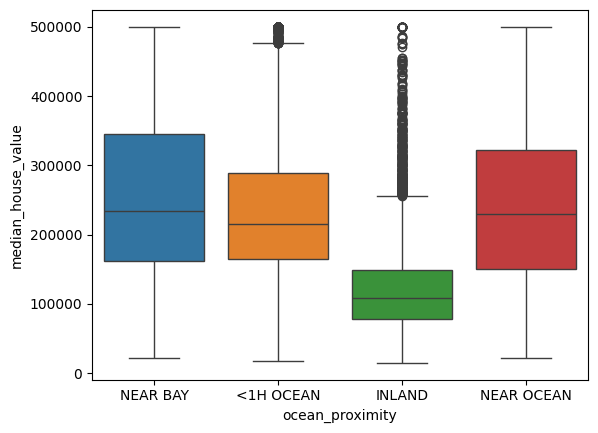

In [53]:
# Ocean proximity has some relationship to median_house_value, but there is a lot
# of overlap of IQR, and many outliers especially in INLAND locations

# Only INLAND has a significantly different mean, so I'll create a single dummy variable for INLAND
sns.boxplot(df[['ocean_proximity','median_house_value']],
            x='ocean_proximity', y='median_house_value', hue='ocean_proximity')

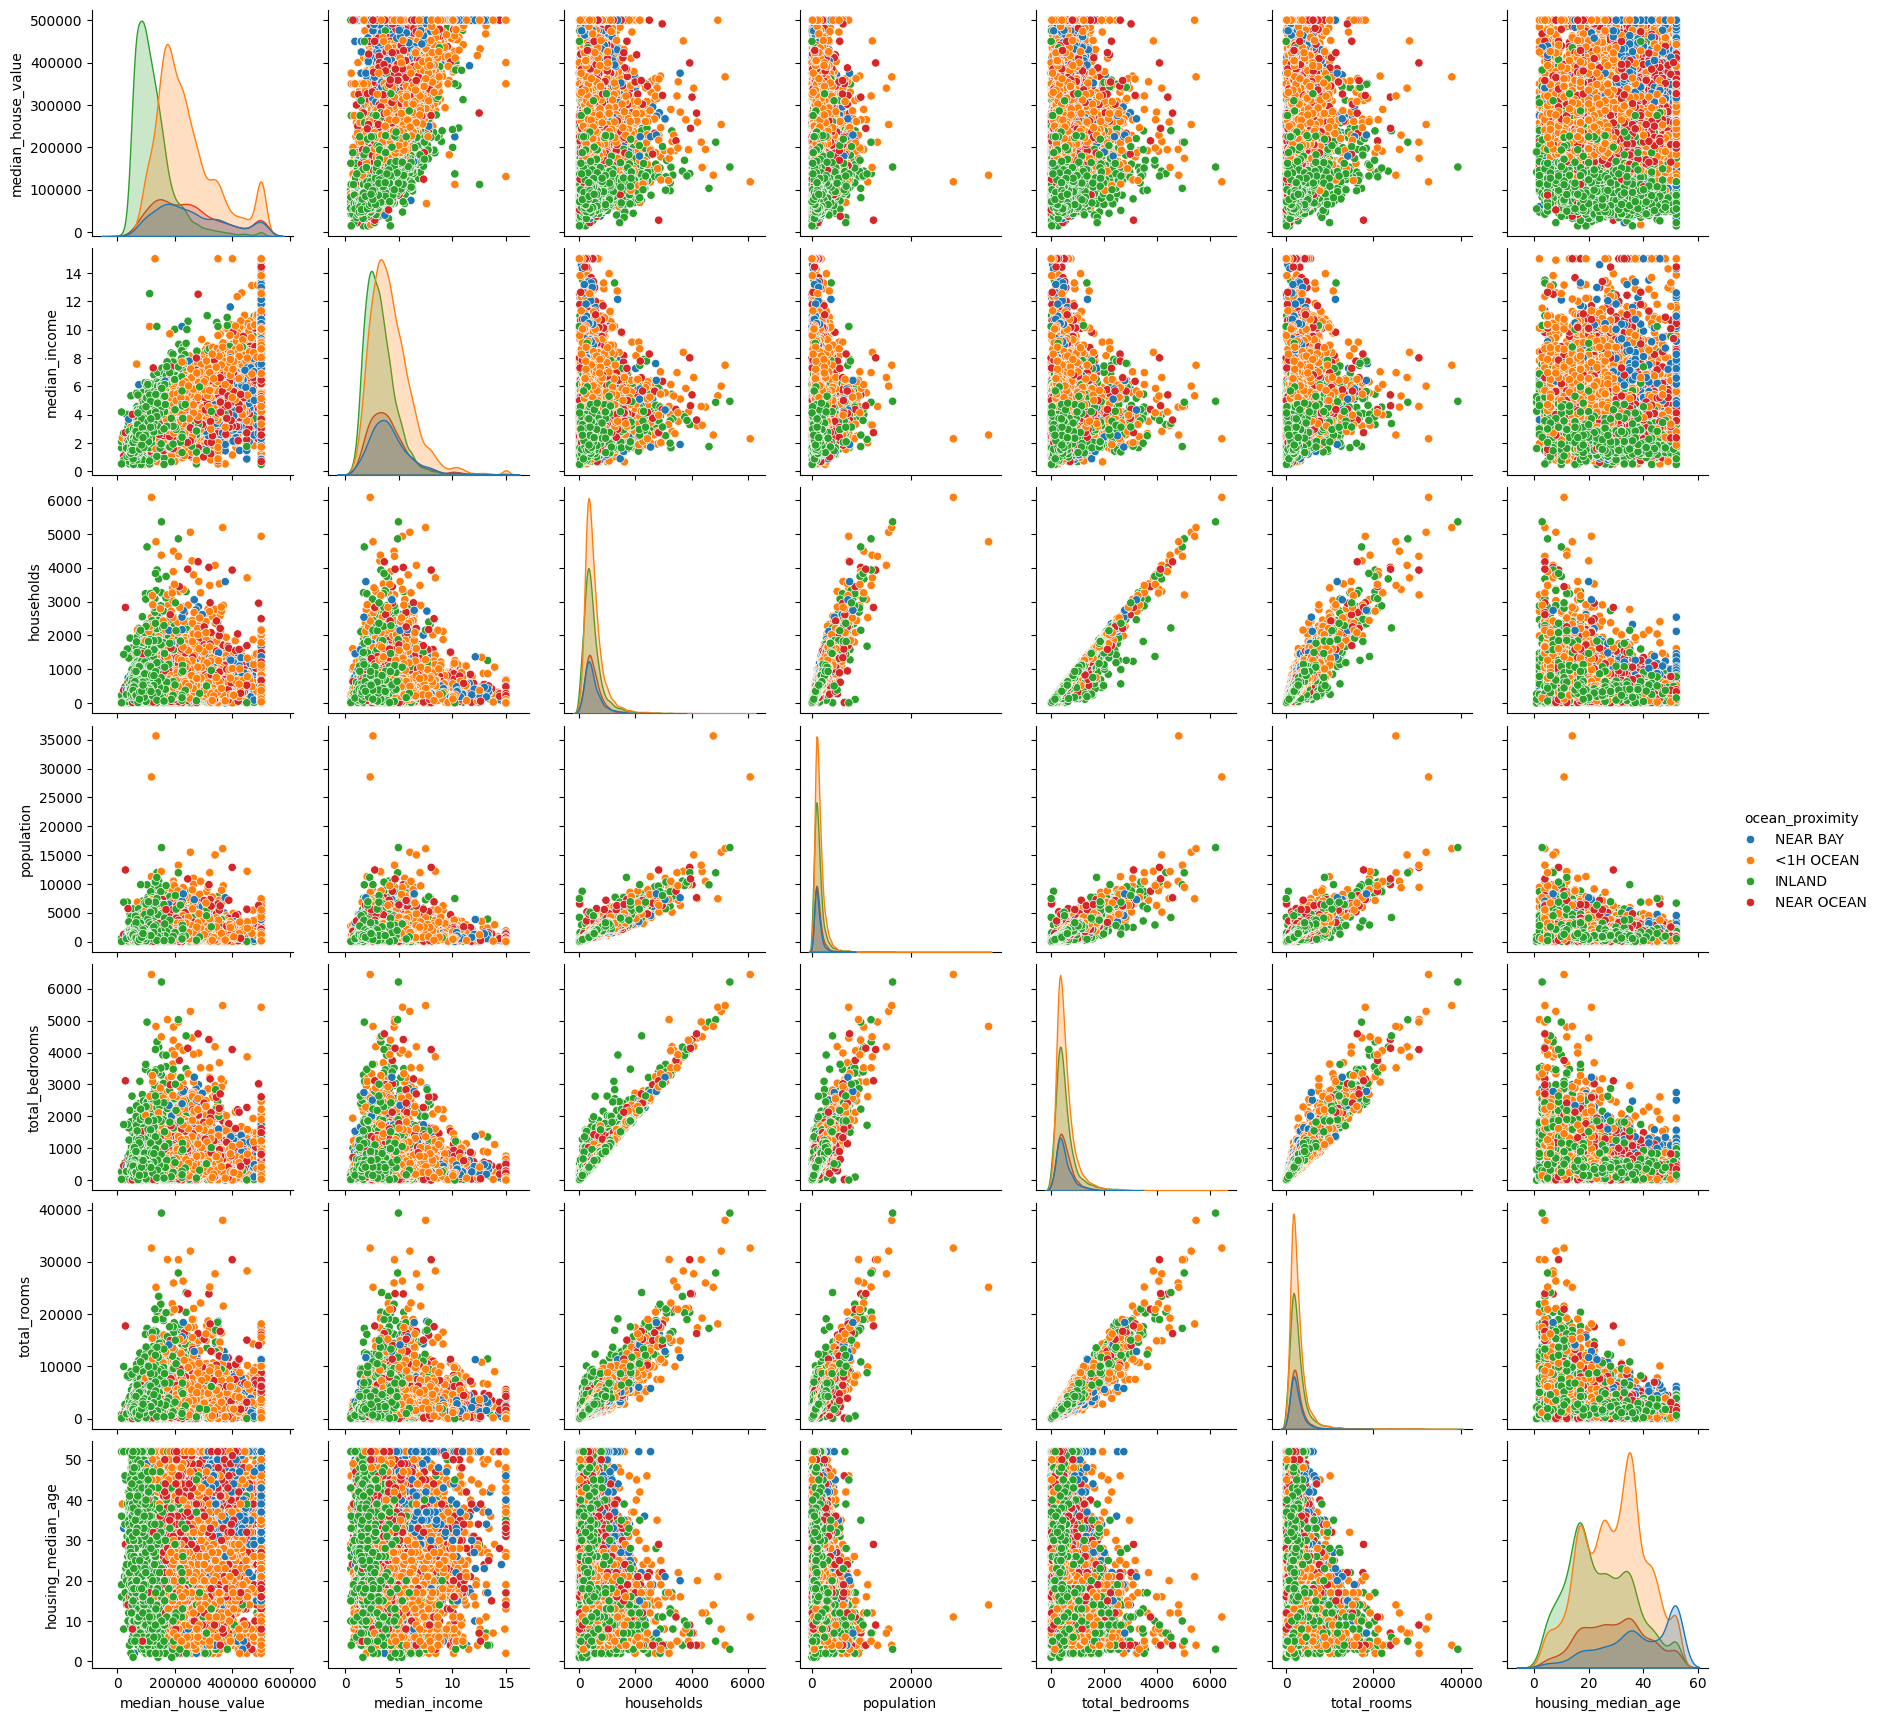

In [57]:
# housing_median_age does not have much correlation to median_house_value
# nor does total_rooms, total_bedrooms, population, or households
sns.pairplot(df[['median_house_value','median_income','households','population',
                 'total_bedrooms','total_rooms','housing_median_age','ocean_proximity']], hue='ocean_proximity')

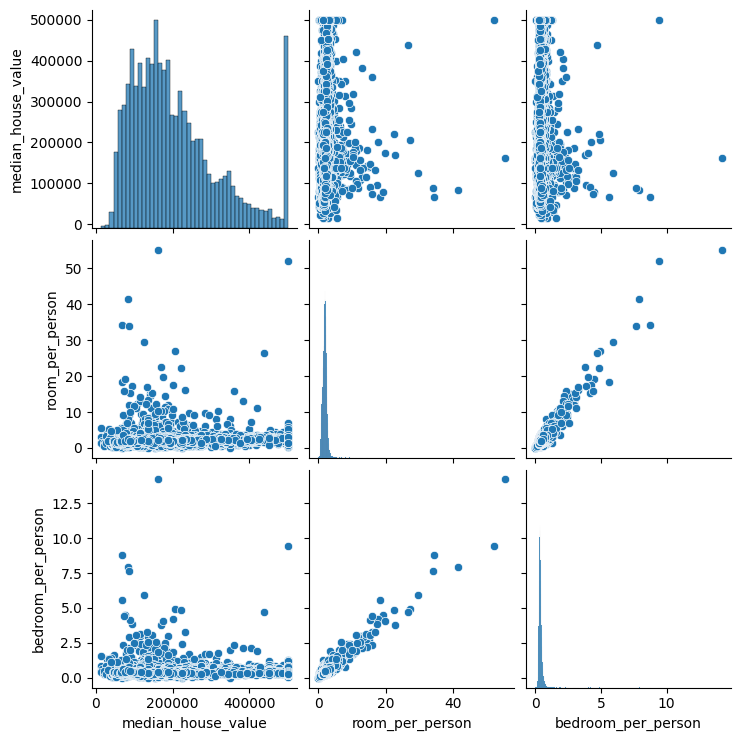

In [93]:
# for total_rooms, total_bedrooms, households, and population, let's see if per person or
# per household features have correlation

# per person rooms/bedrooms does not change the relationship, but the correlation is stronger between them
perPerson = df[['total_rooms','total_bedrooms']].div(df['population'], axis=0)
perPerson = perPerson.rename(columns={'total_rooms':'room_per_person', 'total_bedrooms':'bedroom_per_person'})
tmp = pd.concat([df[['median_house_value']], perPerson], axis=1)
sns.pairplot(tmp)

In [98]:
# Look at correlations
corr = df.drop(columns=['ocean_proximity']).join(perPerson).corr()
corr.style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,room_per_person,bedroom_per_person
longitude,1.000000,-0.924676,-0.108394,0.044642,0.069653,0.099881,0.055400,-0.015090,-0.046208,-0.074481,-0.045201
latitude,-0.924676,1.000000,0.011462,-0.036231,-0.067066,-0.108978,-0.071199,-0.079977,-0.143837,0.140462,0.107605
housing_median_age,-0.108394,0.011462,1.000000,-0.361268,-0.320486,-0.296172,-0.302863,-0.118949,0.105272,-0.108115,-0.057788
total_rooms,0.044642,-0.036231,-0.361268,1.000000,0.930382,0.857117,0.918480,0.197991,0.134373,0.129318,0.053279
total_bedrooms,0.069653,-0.067066,-0.320486,0.930382,1.000000,0.877758,0.979740,-0.007767,0.049792,0.056614,0.098800
population,0.099881,-0.108978,-0.296172,0.857117,0.877758,1.000000,0.907213,0.004737,-0.024421,-0.140473,-0.133409
households,0.055400,-0.071199,-0.302863,0.918480,0.979740,0.907213,1.000000,0.012950,0.066069,-0.028422,0.005539
median_income,-0.015090,-0.079977,-0.118949,0.197991,-0.007767,0.004737,0.012950,1.000000,0.688563,0.237888,-0.053130
median_house_value,-0.046208,-0.143837,0.105272,0.134373,0.049792,-0.024421,0.066069,0.688563,1.000000,0.209412,0.069534
room_per_person,-0.074481,0.140462,-0.108115,0.129318,0.056614,-0.140473,-0.028422,0.237888,0.209412,1.000000,0.904348


In [115]:
# Highly correlated columns:
# total_bedrooms: households
# total_rooms: total_bedrooms
# total_rooms: households
# population: households
corr2 = corr.stack().reset_index()
corr2.columns = ["row",'column','value']
corr2 = corr2.query('row != column').query('value > 0.5').sort_values('value', key=abs, ascending=False)
corr2['n'] = corr2.groupby('value')['value'].rank(method='first')
corr2.query('n == 1.0').drop(columns=['n'])

,row,column,value
50,total_bedrooms,households,0.979740
37,total_rooms,total_bedrooms,0.930382
39,total_rooms,households,0.918480
61,population,households,0.907213
109,room_per_person,bedroom_per_person,0.904348
49,total_bedrooms,population,0.877758
38,total_rooms,population,0.857117
85,median_income,median_house_value,0.688563


In [116]:
# let's drop total_bedrooms, total_rooms, and population, just keeping households
df = df.drop(columns=['total_bedrooms','total_rooms','population'])
df.head()

,longitude,latitude,housing_median_age,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,259.0,3.8462,342200.0,NEAR BAY


### Set up Training and Test Sets

In [141]:
df['is_inland'] = (pd.get_dummies(df[['ocean_proximity']])['ocean_proximity_INLAND'])
df = df.drop(columns='ocean_proximity')
df

,longitude,latitude,housing_median_age,households,median_income,median_house_value,is_inland
0,-122.23,37.88,41.0,126.0,8.3252,452600.0,False
1,-122.22,37.86,21.0,1138.0,8.3014,358500.0,False
2,-122.24,37.85,52.0,177.0,7.2574,352100.0,False
3,-122.25,37.85,52.0,219.0,5.6431,341300.0,False
4,-122.25,37.85,52.0,259.0,3.8462,342200.0,False
...,...,...,...,...,...,...,...
20630,-121.09,39.48,25.0,330.0,1.5603,78100.0,True
20631,-121.21,39.49,18.0,114.0,2.5568,77100.0,True
20632,-121.22,39.43,17.0,433.0,1.7000,92300.0,True
20633,-121.32,39.43,18.0,349.0,1.8672,84700.0,True


In [144]:
trainX, testX, trainY, testY = train_test_split(df.loc[:, df.columns != 'median_house_value'],
                                                df['median_house_value'], random_state=1080, test_size=.3)

### Model Development
- impute total_bedrooms from total_rooms using IterativeImputer
- with/without ocean_proximity

In [194]:
def getMSEsForModel(k):
  pipe = Pipeline([
    ('pfeat', PolynomialFeatures(degree=k, include_bias=False)),
    ('scale', StandardScaler()),
    ('linreg', LinearRegression())])
  pipe.fit(trainX, trainY)
  trainingError = mean_squared_error(pipe.predict(trainX), trainY)
  testingError = mean_squared_error(pipe.predict(testX), testY)
  return k, trainingError, testingError

ks = np.array(range(1,7))

results = []
for k in ks:
  results.append(getMSEsForModel(k))

results = pd.DataFrame(results, columns=['k','TrainingMSE','ValidationMSE'])

In [196]:
results

,k,TrainingMSE,ValidationMSE
0,1,5.116417e+09,5.255573e+09
1,2,4.595186e+09,4.749347e+09
2,3,4.143389e+09,4.418452e+09
3,4,3.826505e+09,4.172676e+09
4,5,3.576440e+09,4.322237e+09
5,6,3.369172e+09,3.321658e+10


<Axes: xlabel='k'>

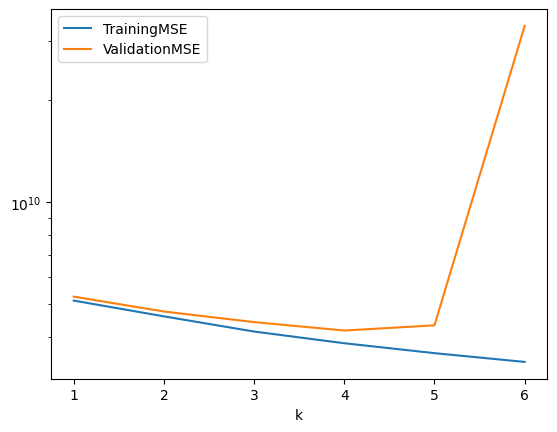

In [197]:
results.set_index('k').plot.line(logy=True)

In [198]:
finalModel = Pipeline([
    ('scale', StandardScaler()),
    ('pfeat', PolynomialFeatures(degree=4, include_bias=False)),
    ('linreg', LinearRegression())])

finalModel.fit(trainX, trainY)
x = permutation_importance(finalModel, trainX, trainY, random_state=1080, n_repeats=10, n_jobs=2)

In [203]:
finalModel.score(trainX, trainY)

0.7117260748456021

In [202]:
x.importances_mean

array([1.34503080e+02, 1.78740624e+02, 1.31627939e-01, 7.69271443e-02,
       8.30580892e-01, 1.26727868e+00])

<Axes: >

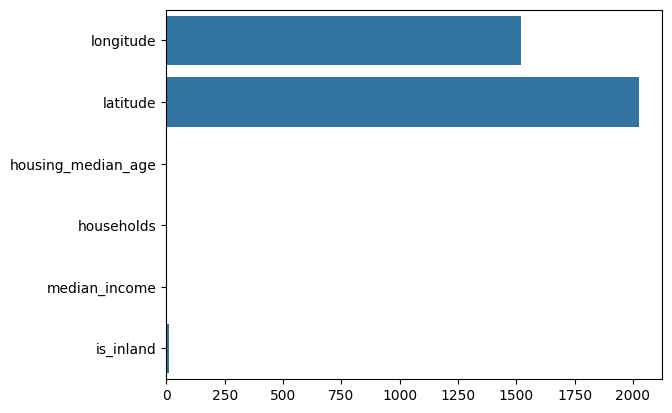

In [188]:
sns.barplot(y=finalModel.feature_names_in_, x=x.importances_mean)
# finalModel.feature_names_in_
# importances.importances_mean